# Proof of Concept
Neste notebooks tem os um prova de conceito encima do tema do TCC:
<br/>
**ANÁLISE COMPARATIVA DE TÉCNICAS PARA A PREVISÃO DE SÉRIES TEMPORAIS NO CONTEXTO DE MERCADOS FINANCEIROS**

#### Métodos Comparados
- AR
- ARMA
- ARIMA
- ARIMA-GARCH
- VAR
- 

## Imports

In [556]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
import statistics

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf

# Other
from IPython.display import Image
import warnings
import pprint
import datetime
import os

## Prepare Principal Directory

In [557]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname (os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}' 

In [558]:
prepare_directory_work(end_directory='notebooks')

'Current working directory: /home/campos/projects/tcc'

## Cell Format

In [559]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Guarantees visualization inside the jupyter
%matplotlib inline

# Print xxxx rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# pretty print
pp = pprint.PrettyPrinter(indent=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [560]:
plt.style.use('seaborn')  # fivethirtyeight
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

## Load Data

In [561]:
%%time

df_vale3 = pd.read_csv('data/raw/vale3_2010-2020.csv',
                              encoding='utf8',
                              delimiter=',',
                              verbose=True)

Tokenization took: 0.50 ms
Type conversion took: 1.71 ms
Parser memory cleanup took: 0.00 ms
CPU times: user 5.99 ms, sys: 226 µs, total: 6.22 ms
Wall time: 5.64 ms


In [562]:
print(df_vale3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2495 non-null   object 
 1   Price     2495 non-null   float64
 2   Open      2495 non-null   float64
 3   High      2495 non-null   float64
 4   Low       2495 non-null   float64
 5   Vol.      2495 non-null   object 
 6   Change %  2495 non-null   object 
dtypes: float64(4), object(3)
memory usage: 136.6+ KB
None


In [563]:
df_vale3.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jun 19, 2020",55.170000,56.330000,56.600000,54.710000,37.86M,-1.78%
1,"Jun 18, 2020",56.170000,56.300000,56.540000,55.610000,25.69M,-0.05%
2,"Jun 17, 2020",56.200000,55.490000,56.440000,55.150000,27.57M,1.46%
3,"Jun 16, 2020",55.390000,55.490000,55.500000,54.220000,29.17M,2.80%
4,"Jun 15, 2020",53.880000,52.500000,54.430000,52.130000,27.32M,0.90%


## Columns

In [564]:
df_vale3.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

#### Drop Columns

In [565]:
df_vale3.drop(['Open'], axis=1, inplace=True)
df_vale3.drop(['High'], axis=1, inplace=True)
df_vale3.drop(['Low'], axis=1, inplace=True)
df_vale3.drop(['Vol.'], axis=1, inplace=True)
df_vale3.drop(['Change %'], axis=1, inplace=True)

#### lower()

In [566]:
df_vale3.columns =  map(str.lower, df_vale3.columns)
print(df_vale3.columns)

Index(['date', 'price'], dtype='object')


## Duplicate Records

In [567]:
df_vale3.isnull().any()

date     False
price    False
dtype: bool

## Missing values

In [568]:
df_vale3.duplicated().any()

False

## Format Date

In [569]:
df_vale3['date'] = pd.to_datetime(df_vale3['date'])
print(df_vale3['date'].head())

0   2020-06-19
1   2020-06-18
2   2020-06-17
3   2020-06-16
4   2020-06-15
Name: date, dtype: datetime64[ns]


## Use `date` how index

In [570]:
df_vale3.index.names = ['date']
df_vale3.index = df_vale3['date']
df_vale3.index = pd.to_datetime(df_vale3.index)

print(df_vale3.index.freq)
print(df_vale3.index)

None
DatetimeIndex(['2020-06-19', '2020-06-18', '2020-06-17', '2020-06-16',
               '2020-06-15', '2020-06-12', '2020-06-10', '2020-06-09',
               '2020-06-08', '2020-06-05',
               ...
               '2010-06-02', '2010-06-01', '2010-05-31', '2010-05-28',
               '2010-05-27', '2010-05-26', '2010-05-25', '2010-05-24',
               '2010-05-21', '2010-05-20'],
              dtype='datetime64[ns]', name='date', length=2495, freq=None)


#### Remove date col

In [571]:
df_vale3.drop(['date'], axis=1, inplace=True)

In [572]:
print(df_vale3.head())

               price
date                
2020-06-19 55.170000
2020-06-18 56.170000
2020-06-17 56.200000
2020-06-16 55.390000
2020-06-15 53.880000


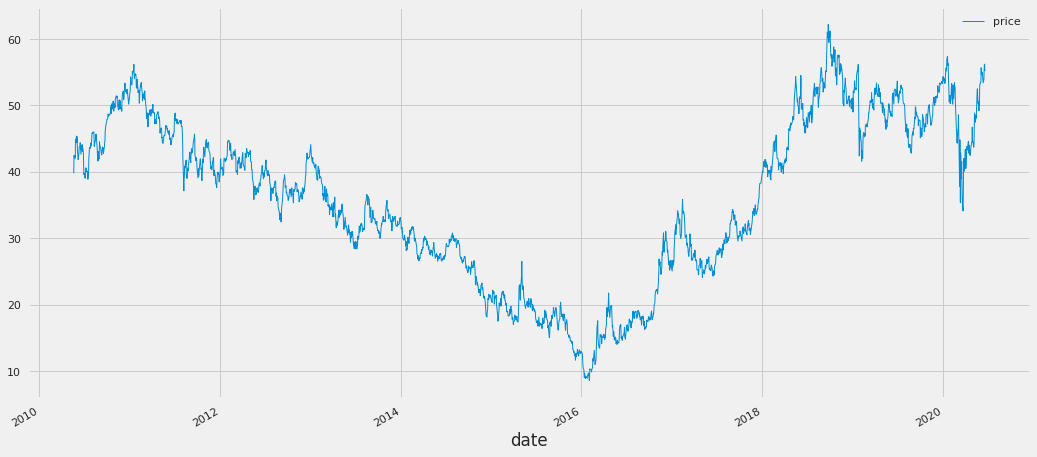

In [573]:
df_vale3.plot(linewidth=1)
plt.grid(True)

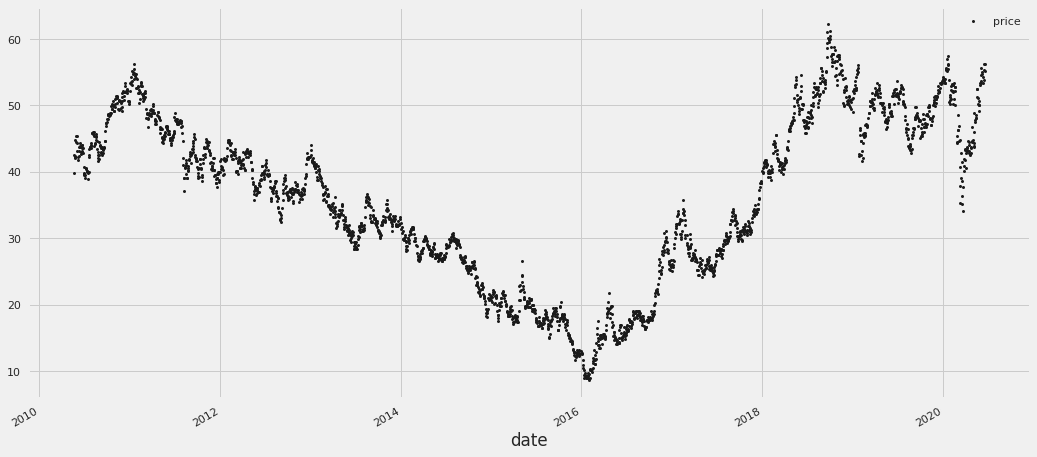

In [574]:
df_vale3.plot(style='k.')
plt.grid(True)

## Train and Test

In [575]:
size_train = int(len(df_vale3)*0.8)
size_test = int(len(df_vale3)*0.2)

print(size_train)
print(size_test)

1996
499


In [576]:
train = df_vale3.iloc[:size_train]
test = df_vale3.iloc[size_train:]

print(len(train))
print(len(test))

1996
499


## Metric to Evaluation

In [577]:
# Function for mean_absolute_percentage_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Statistic Models

#### AR

In [578]:
model_ar = ARIMA(train['price'], order=(1, 0, 0))  
results_ar = model_ar.fit()


print(results_ar.summary().tables[1])

                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.0417      7.018      5.278      0.000      23.286      50.797
ar.L1.price     0.9974      0.002    662.115      0.000       0.994       1.000


NameError: name 'results_ARIMA' is not defined

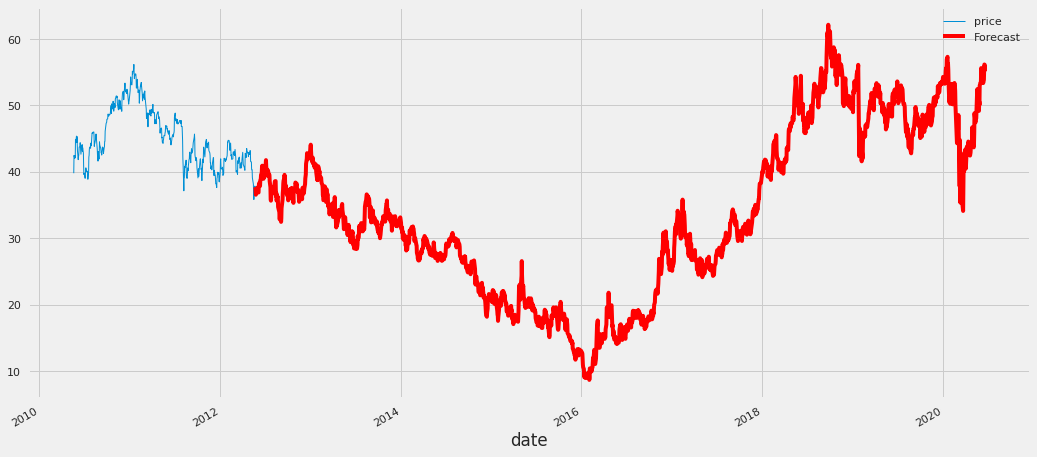

In [581]:
df_vale3['price'].plot(linewidth=1)
results_ar.fittedvalues.shift(-1).plot(color='red', label='Forecast')
plt.legend()
plt.grid(True)


mape = mean_absolute_percentage_error(y_true=df_vale3['price'],
                               y_pred=results_ARIMA.fittedvalues.shift(-1))

plt.title('Mean Square Error: %.0f'% mape)